In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import histlite as hl
import csky as cy
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from scipy import stats

In [3]:
mpl.rcParams['font.size'] = 20

In [4]:
ana_dir = cy.utils.ensure_dir('/home/jthwaites/csky_cache')
ana = cy.get_analysis(cy.selections.repo, 'version-002-p05', cy.selections.GFUDataSpecs.GFU_IC86_2011_2018, 
                dir=ana_dir)
    
conf = {'extended': True,
        'space': "ps",
        'time': "transient",
        'sig': 'transient',
        }
cy.CONF['ana'] = ana

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2013_data.npy ...
Reading /data/a

In [5]:
def load_frbs(make_skymap=False):
    with open('./repeaters.txt') as json_file:
        repeaters = json.load(json_file)

    rep_source={'src':[],'coord':[],'mjd':[]}
    ra=[]
    dec=[]
    for source in repeaters:
        rep_source['src'].append(source)
        ra.append(repeaters[source]['ra']['value'])
        dec.append(repeaters[source]['dec']['value'])    
        times=[]
        for key in repeaters[source]:
            if key != 'dm' and key !='ymw16' and key!='dec' and key!='gl' and key!='gb' and key!= 'ra' and \
                key!='localized' and key!='last_burst_date' and key!='publication' and key!='ne2001' and \
                key!='previous_name': 
                times.append(Time(repeaters[source][key]['timestamp']['value'],format ='iso').mjd)
        rep_source['mjd'].append(times)
    rep_source['coord']=SkyCoord(ra=ra,dec=dec, unit=(u.hourangle,u.deg))
    
    frbs = pd.read_csv('./frbs_wout_chime.csv')
    
    frbs_coord = SkyCoord(ra=frbs['rop_raj'], dec=frbs['rop_decj'], unit=(u.hourangle, u.deg))
    frbs_mjd = np.asarray([Time(t.replace('/', '-'), format='iso').mjd for t in frbs['utc']])

    #choose northern FRB: 33 deg dec for FRB121102
    wn=np.where(frbs['frb_name']=='FRB121102')
    #choose southern FRB: -35 deg dec for FRB180110
    ws=np.where(frbs['frb_name']=='FRB180110')
    
    all_ras=[]
    all_dec=[]
    all_mjd=[]
    for i in range(len(frbs_coord.ra)):
        all_ras.append(frbs_coord[i].ra.deg)
        all_dec.append(frbs_coord[i].dec.deg)
        all_mjd.append(frbs_mjd[i])

    for i in range(len(rep_source['src'])):
        for j in range(len(rep_source['mjd'][i])):
            all_ras.append(rep_source['coord'][i].ra.deg)
            all_dec.append(rep_source['coord'][i].dec.deg)
            all_mjd.append(rep_source['mjd'][i][j])
    if make_skymap==True:
        dec=[d for d in frbs_coord.dec.rad]
        dec2=[d for d in rep_srcs.dec.rad]
        ra=[d for d in frbs_coord.ra.rad]
        ra2=[d for d in rep_srcs.ra.rad]
        make_frb_skymap(ra+ra2,dec+dec2)
        
    return all_ras, all_dec, all_mjd, wn, ws

In [6]:
#build source object
def sources(t_s): #time window (sec)
    src = cy.utils.Sources(
        ra=all_ras,
        dec=all_dec, 
        mjd=all_mjd,
        t_100=[t_s/84600.]*len(all_ras), #in mjd
        sigma_t=[0.]*len(all_ras),
        deg=True)
    return src

def make_frb_skymap(ra, dec, print_plot=True):    
    src_map = hl.heal.hist(128, dec, ra)

    fig, ax = plt.subplots(figsize=(10,6),subplot_kw=dict(projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='Blues',vmin=0))
    mesh, cb = sp.plot_map(ax, np.where(src_map.map>0, src_map.map, np.nan), n_ticks=2)
    kw = dict(color='.5', alpha=.5)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    plt.title('Skymap of FRB locations \n')
    cb.set_label(r'FRBs/bin')
    
    if print_plot==False: plt.show()
    else: plt.savefig('./plots/frb_skymap.png')

In [11]:
all_ras, all_dec, all_mjd,wn,ws =load_frbs(make_skymap=False)

In [12]:
def bg_ts_trials(src, n_trials=10000, frb_name = ' ', print_plot=False):
    tr=cy.get_trial_runner(conf,ana=ana,src=src)
    
    #running bg trials
    trials=tr.get_many_fits(n_trials)
    bg = cy.dists.Chi2TSD(trials)
    if np.count_nonzero(trials.ts)==0:
        print('no nonzero TS values')
    
    if print_plot==True: 
        fig, ax = plt.subplots(figsize=(9,6))
        h = bg.get_hist(bins=50)
        hl.plot1d(ax, h, crosses=True, label='%i bg trials'%(bg.n_total))

        # compare with the chi2 fit:
        x = h.centers[0][1:] #remove zero TS bin from curve: not fitted here
        norm = h.integrate().values #normalization for chi-sq
        ax.semilogy(x, norm * bg.pdf(x), lw=1, label=r'$\chi^2$[%.2f dof, $\eta$=%.3f]'%(bg.ndof, bg.eta))

        ax.set_xlabel(r'TS')
        ax.set_ylabel(r'$N$')
        if src['t_100'][0]==1.: plt.title(r'BG TS distribution, %s (1d)'%(frb_name))
        else: plt.title(r'BG TS distribution, %s (%is)'%(frb_name,src['t_100'][0]*84600.))
        ax.legend()
        plt.savefig('./plots/%s_bgts_%is.png'%(frb_name,int(src['t_100'][0]*84600.)))
    return bg

In [13]:
def sens_dp(src, beta=0.9, nsigma=5, gamma=2., n_trials=10000): #beta is %, nsigma is # of sigma for dp
    bg=bg_ts_trials(src, n_trials)
    tr=cy.get_trial_runner(conf,ana=ana,src=src,inj_conf={'flux':cy.hyp.PowerLawFlux(gamma)})
    #sensitivity
    sens=tr.find_n_sig(bg.median(),0.9, tol=0.03,n_batches=10,n_sig_step=1, logging=False)
    #discovery potential
    disc = tr.find_n_sig(bg.isf_nsigma(nsigma), beta, tol=0.03,n_batches=10,n_sig_step=1, logging=False)
    return sens, disc

def pf_plot(src, sens, disc, nsigma=5, gamma=2., frb_name=' ', print_plot=False, show_chisq=True):
    fig, ax = plt.subplots(figsize=(9,6))
    mpl.rcParams['font.size'] = 15
    
    xs = np.linspace(0., max(sens['info']['n_sigs']), 500)
    xs_dp = np.linspace(0., max(disc['info']['n_sigs']), 500)
    
    chi2cdf = lambda n: stats.chi2.cdf(n, *sens['info']['params'])
    chi2cdf_dp = lambda n: stats.chi2.cdf(n, *disc['info']['params'])
    
    plt.errorbar(sens['info']['n_sigs'], sens['info']['CLs'], 
             yerr=sens['info']['sigmas'], label = 'Sensitivity')
    plt.errorbar(disc['info']['n_sigs'],disc['info']['CLs'], 
             yerr=disc['info']['sigmas'], label = r'%i$\sigma$ Discovery potential'%nsigma)
    
    if show_chisq==True:
        plt.plot(xs, chi2cdf(xs), label = 'sensitivity Chi2CDF fit')
        plt.axvline(sens['info']['n_sig_chi2cdf'], ls='--')
        plt.plot(xs_dp, chi2cdf_dp(xs_dp), label = 'DP Chi2CDF fit')
        plt.axvline(disc['info']['n_sig_chi2cdf'], ls='--')
        
    plt.legend(loc=4)
    plt.xlabel(r'$n_{\mathrm{inj}}$')
    plt.ylabel(r'Fraction TS $>$ threshold')
    
    if int(src['t_100'][0]) == 1: 
        plt.title(r'passing fraction, %s (1d)'%(frb_name))
    else: 
        plt.title(r'passing fraction, %s (%is)'%(frb_name,src['t_100'][0]*84600.))
    
    if print_plot==False: plt.show()
    else: plt.savefig('./plots/%s_pf_%is_%.1f.png'%(frb_name,int(src['t_100'][0]*84600.),gamma))
        
    print(r'Sensitivity: %.3f +/- %.3f'%(sens['n_sig'], sens['n_sig_error']))
    print(r'Discovery Potential: %.3f +/- %.3f'%(disc['n_sig'], disc['n_sig_error']))

In [14]:
src1d = sources(84600)
src1000 = sources(1000)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   


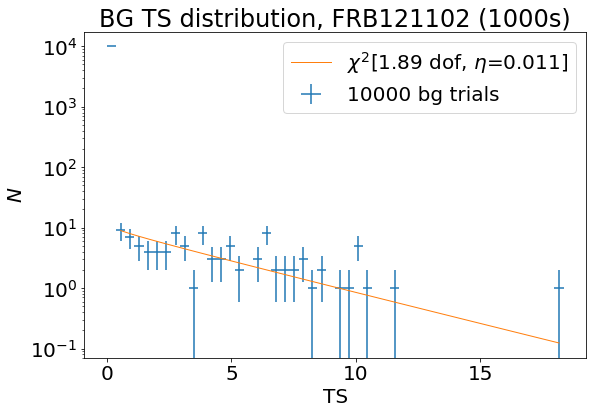

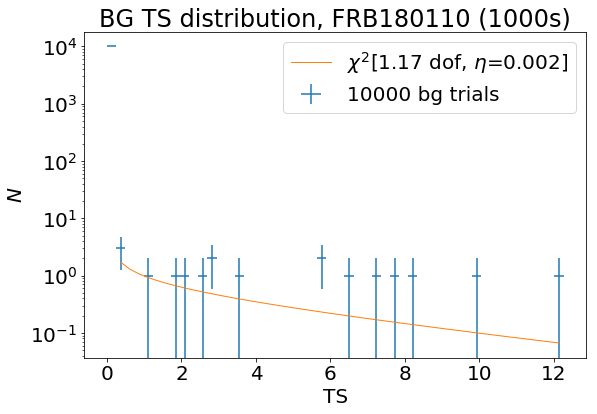

In [19]:
bg_ts_trials(src1000[wn], frb_name='FRB121102', print_plot=True)
bg_ts_trials(src1000[ws], frb_name='FRB180110', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   


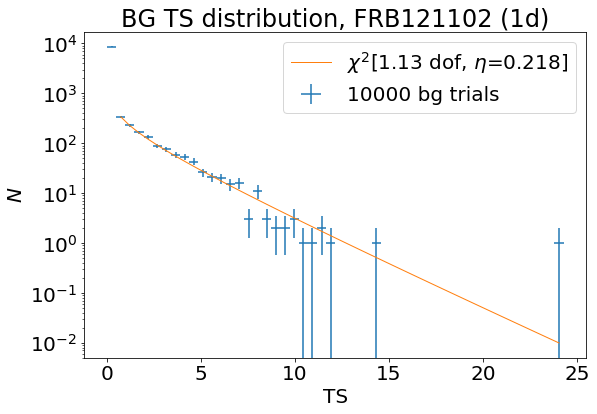

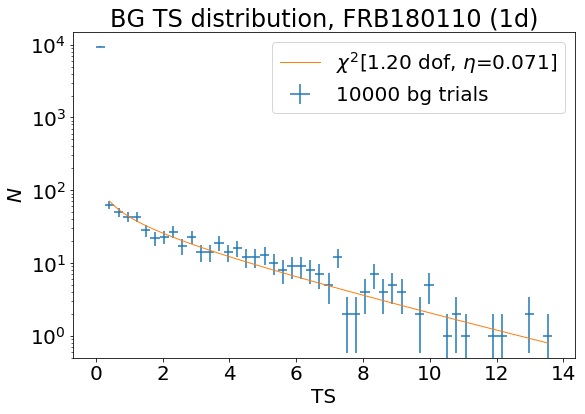

In [20]:
md_n_1d=bg_ts_trials(src1d[wn], frb_name='FRB121102', print_plot=True)
md_s_1d=bg_ts_trials(src1d[ws], frb_name='FRB180110', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Sensitivity: 2.506 +/- 0.022
Discovery Potential: 6.614 +/- 0.028
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Sensitivity: 2.409 +/- 0.030
Discovery Potential: 8.250 +/- 0.028


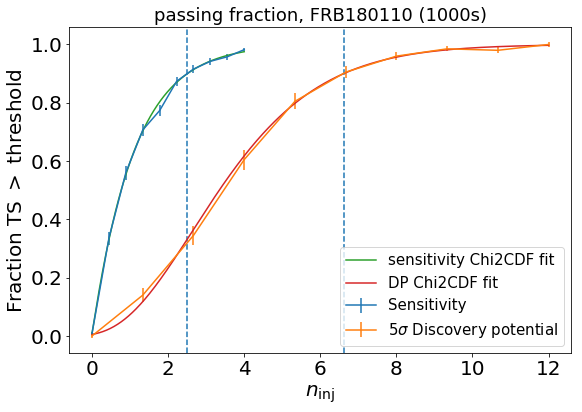

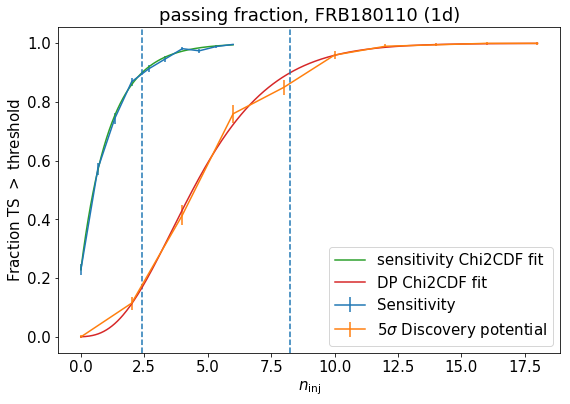

In [18]:
sens,dp = sens_dp(src1000[wn])
pf_plot(src1000[wn],sens, dp, frb_name='FRB180110', print_plot=True)

sens,dp = sens_dp(src1d[wn])
pf_plot(src1d[wn],sens, dp, frb_name='FRB180110', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Sensitivity: 2.433 +/- 0.029
Discovery Potential: 7.138 +/- 0.025
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Sensitivity: 2.317 +/- 0.028
Discovery Potential: 7.880 +/- 0.029


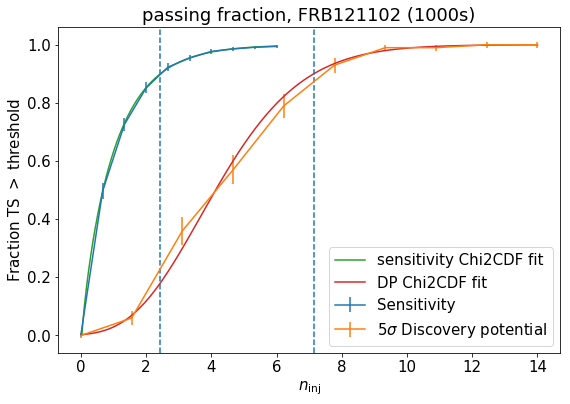

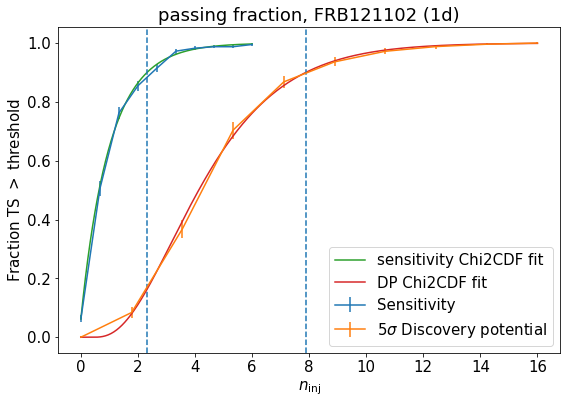

In [19]:
sens,dp = sens_dp(src1000[ws])
pf_plot(src1000[ws],sens, dp, frb_name='FRB121102', print_plot=True)

sens,dp = sens_dp(src1d[ws])
pf_plot(src1d[ws],sens, dp, frb_name='FRB121102', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Sensitivity: 2.464 +/- 0.027
Discovery Potential: 8.307 +/- 0.027
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Sensitivity: 2.508 +/- 0.030
Discovery Potential: 8.978 +/- 0.023


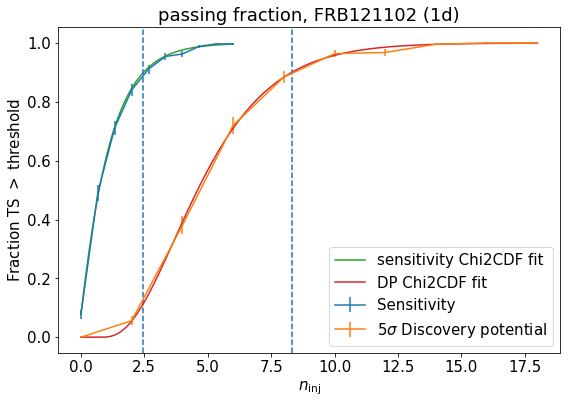

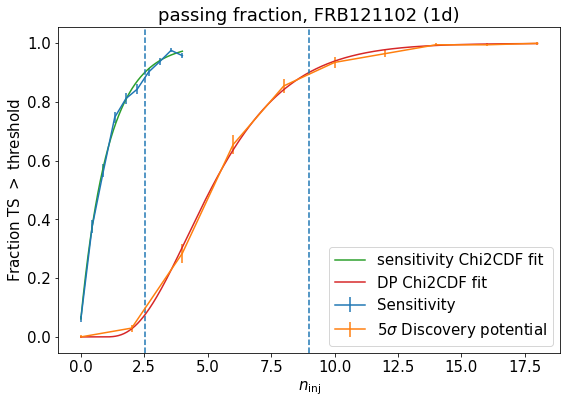

In [18]:
sens,dp = sens_dp(src1d[ws], gamma=2.5)
pf_plot(src1d[ws],sens, dp, gamma=2.5, frb_name='FRB121102', print_plot=True)

sens,dp = sens_dp(src1d[ws], gamma=3.)
pf_plot(src1d[ws],sens, dp, gamma=3., frb_name='FRB121102', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Sensitivity: 2.371 +/- 0.028
Discovery Potential: 7.109 +/- 0.026
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Sensitivity: 2.375 +/- 0.029
Discovery Potential: 7.883 +/- 0.025


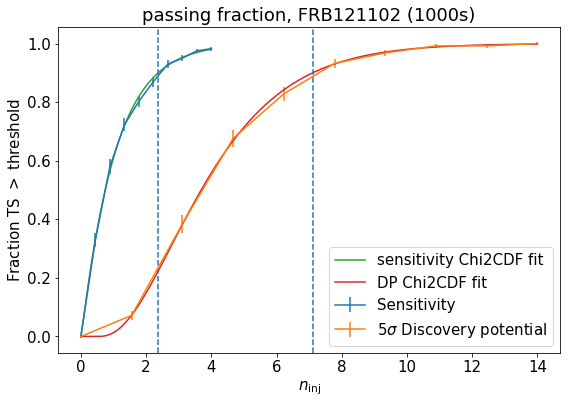

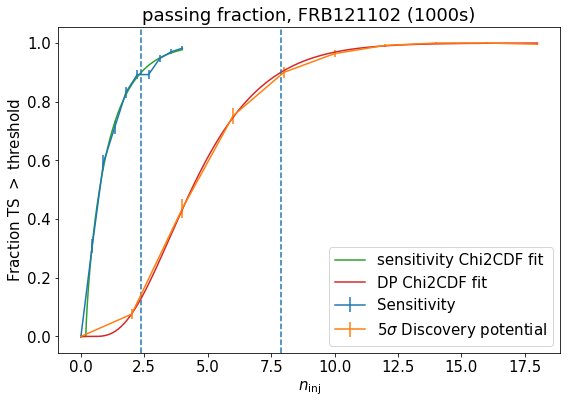

In [17]:
sens,dp = sens_dp(src1000[ws], gamma=2.5)
pf_plot(src1000[ws],sens, dp, gamma=2.5, frb_name='FRB121102', print_plot=True)

sens,dp = sens_dp(src1000[ws], gamma=3.)
pf_plot(src1000[ws],sens, dp, gamma=3., frb_name='FRB121102', print_plot=True)

### Fit bias test

In [81]:
def bias_test(src, gamma=2., nsig_max=100, frb_name=' ', print_plot=True):
    n_sigs = np.r_[:nsig_max+1:5]
    tr=cy.get_trial_runner(conf,ana=ana,src=src,inj_conf={'flux':cy.hyp.PowerLawFlux(gamma)})
    trials = [tr.get_many_fits(100, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]
    
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    
    
    fig, axs = plt.subplots(1, 2, figsize=(14,6))

    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=2)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    ax = axs[0]
    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
    if int(src['t_100'][0]) == 1: 
        ax.set_title(r'%s (1d)'%(frb_name))
    else: 
        ax.set_title(r'%s (%i)'%(frb_name,src['t_100'][0]*84600.))

    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax = axs[1]
    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
    ax.axhline(expect_gamma, **expect_kw)
    ax.set_xlim(axs[0].get_xlim())

    for ax in axs:
        ax.set_xlabel(r'$n_{inj}$')
        ax.grid()
        
    axs[0].set_ylabel(r'$n_s$')
    axs[1].set_ylabel(r'$\gamma$')

    if print_plot==True: plt.savefig('./plots/nbias_%s_%i_%.1f.png'%(frb_name,int(src['t_100'][0]*84600.),gamma))
    else: plt.tight_layout()

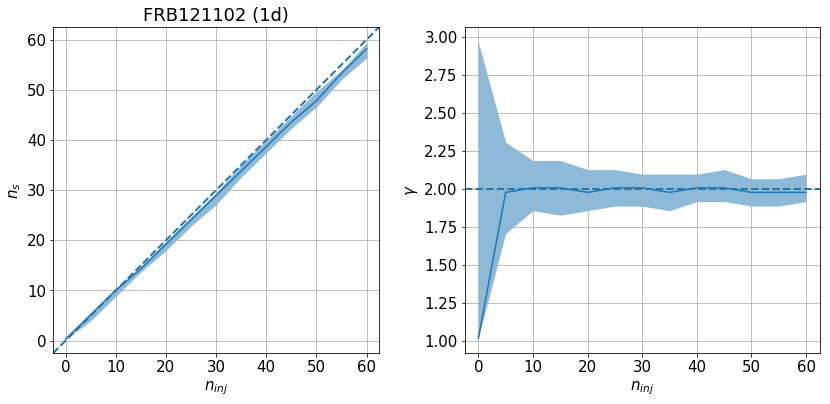

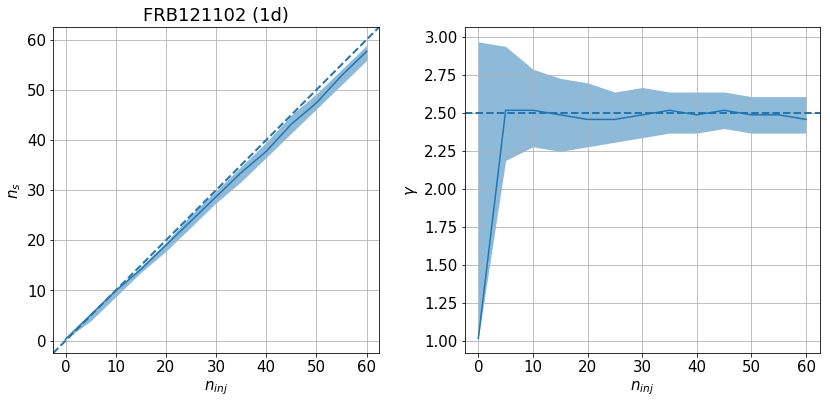

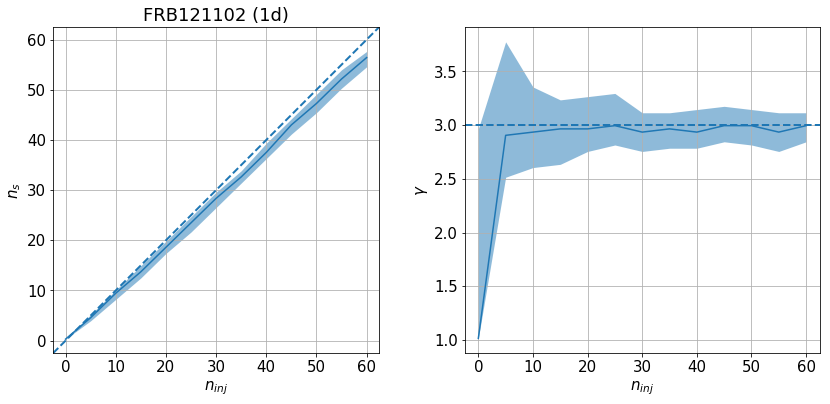

In [86]:
bias_test(src1d[ws],nsig_max=60,frb_name='FRB121102', gamma=2.)
bias_test(src1d[ws],nsig_max=60,frb_name='FRB121102', gamma=2.5)
bias_test(src1d[ws],nsig_max=60,frb_name='FRB121102', gamma=3.)

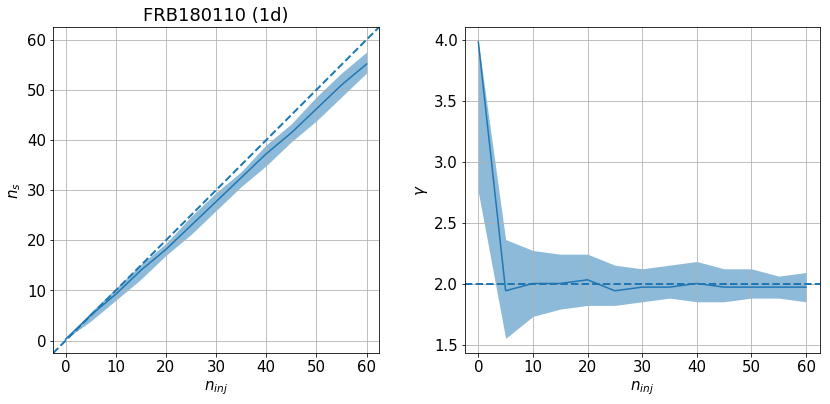

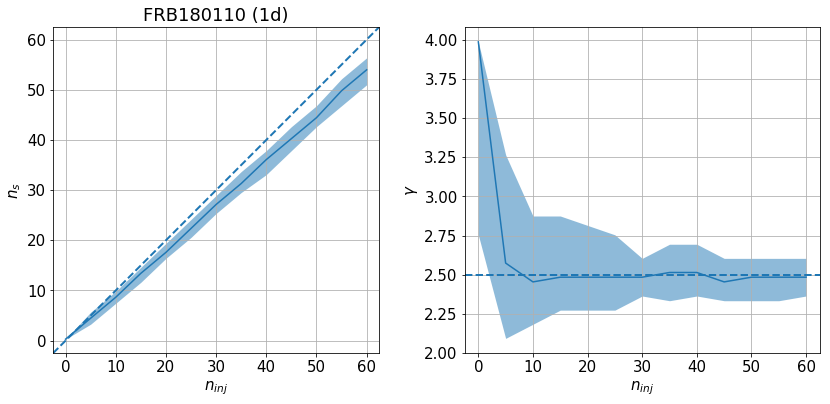

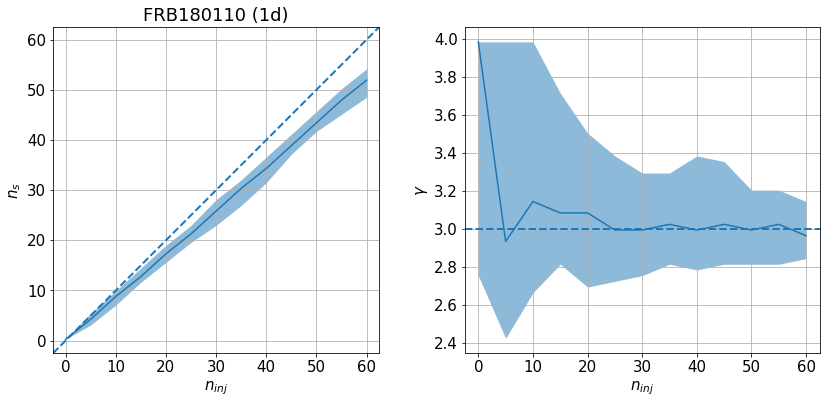

In [85]:
bias_test(src1d[wn],nsig_max=60,frb_name='FRB180110', gamma=2.)
bias_test(src1d[wn],nsig_max=60,frb_name='FRB180110', gamma=2.5)
bias_test(src1d[wn],nsig_max=60,frb_name='FRB180110', gamma=3.)

In [ ]:
#print(tr.to_E2dNdE(sens, E0=100, unit=1e3))#100 TeV cm^-2 
#print(tr.to_E2dNdE(sens))
#print(tr.to_E2dNdE(sens, E0=1, unit=1))#GeV cm^-2

### Sens/DP at different times

In [38]:
#old
def sens_times(t_100,src_ind=False):
    srcs=sources(t_100)
    tr=cy.get_trial_runner(conf,ana=ana,src=srcs[src_ind])
    trials=tr.get_many_fits(10000)
    if np.count_nonzero(trials.ts)==0: return
    
    bg = cy.dists.Chi2TSD(trials)
    tr=cy.get_trial_runner(conf,ana=ana,src=srcs[src_ind],inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    sens=tr.find_n_sig(bg.median(),0.9, tol=0.03,n_sig_step=1, logging=False)
    
    return sens['n_sig'], sens['n_sig_error'], tr.to_E2dNdE(sens, E0=1, unit=1)

In [18]:
def sens_dp_dt(t_100,src_ind=False,beta=0.9, nsigma=5, n_trials=10000): #beta is %, nsigma is # of sigma for dp
    srcs=sources(t_100)
    
    if src_ind==False: tr=cy.get_trial_runner(conf,ana=ana,src=srcs)
    else: tr=cy.get_trial_runner(conf,ana=ana,src=srcs[src_ind])
    trials=tr.get_many_fits(n_trials, logging=False)
    if np.count_nonzero(trials.ts)==0: return
    
    bg = cy.dists.Chi2TSD(trials)
    if src_ind==False: 
        tr=cy.get_trial_runner(conf,ana=ana,src=srcs,inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    else: tr=cy.get_trial_runner(conf,ana=ana,src=srcs[src_ind],inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    sens=tr.find_n_sig(bg.median(),0.9, tol=0.03,n_sig_step=1, logging=False)
    print("sensitivity: %.3f +/- %.3f"%(sens['n_sig'], sens['n_sig_error']))
    disc = tr.find_n_sig(bg.isf_nsigma(nsigma), beta, tol=0.03,n_sig_step=1, logging=False)
    print("DP: %.3f +/- %.3f"%(disc['n_sig'], disc['n_sig_error']))
    
    fl=[tr.to_E2dNdE(sens, E0=1, unit=1), tr.to_E2dNdE(disc, E0=1, unit=1)]
    return sens, disc, fl

In [19]:
sensit=[]
sens_err=[]
sens_fl=[]
dp=[]
dp_err=[]
dp_fl=[]
for t_i in np.logspace(2,7,num=20):
    print('-->t=%i sec'%t_i)
    
    sens,disc,fl= sens_dp_dt(t_i, src_ind=wn)
    sensit.append(sens['n_sig'])
    dp.append(disc['n_sig'])
    
    sens_err.append(sens['n_sig_error'])
    dp_err.append(disc['n_sig_error'])
    
    sens_fl.append(fl[0])
    dp_fl.append(fl[1])

-->t=100 sec
sensitivity: 2.513 +/- 0.026
DP: 5.994 +/- 0.029
-->t=183 sec
sensitivity: 2.417 +/- 0.029
DP: 5.078 +/- 0.026
-->t=335 sec
sensitivity: 2.478 +/- 0.029
DP: 7.358 +/- 0.028
-->t=615 sec
sensitivity: 3.553 +/- 0.020
DP: 6.464 +/- 0.028
-->t=1128 sec
sensitivity: 2.428 +/- 0.027
DP: 7.540 +/- 0.029
-->t=2069 sec
sensitivity: 2.452 +/- 0.028
DP: 7.147 +/- 0.025
-->t=3792 sec
sensitivity: 2.531 +/- 0.030
DP: 7.609 +/- 0.027
-->t=6951 sec
sensitivity: 2.529 +/- 0.029
DP: 6.598 +/- 0.028
-->t=12742 sec
sensitivity: 2.510 +/- 0.028
DP: 7.323 +/- 0.026
-->t=23357 sec
sensitivity: 2.401 +/- 0.029
DP: 7.033 +/- 0.027
-->t=42813 sec
sensitivity: 2.410 +/- 0.028
DP: 7.369 +/- 0.028
-->t=78475 sec
sensitivity: 2.309 +/- 0.026
DP: 7.385 +/- 0.028
-->t=143844 sec
sensitivity: 2.399 +/- 0.028
DP: 8.507 +/- 0.029
-->t=263665 sec
sensitivity: 2.391 +/- 0.026
DP: 8.801 +/- 0.024
-->t=483293 sec
sensitivity: 2.443 +/- 0.028
DP: 9.687 +/- 0.028
-->t=885866 sec
sensitivity: 2.407 +/- 0.026
DP: 

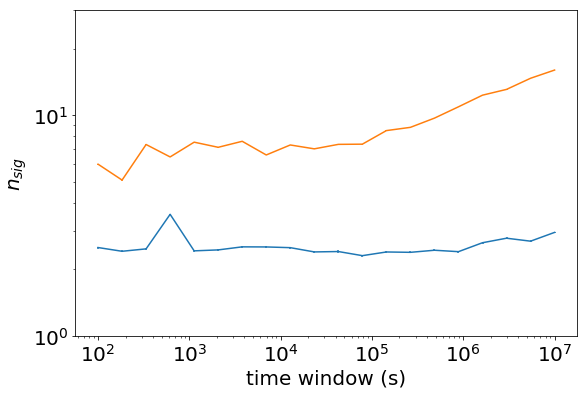

In [26]:
fig,axs = plt.subplots(1,figsize=(9,6))
ts=np.logspace(2,7,num=20)
axs.errorbar(ts, sensit, yerr=sens_err)
axs.errorbar(ts, dp, yerr=dp_err)
axs.set(ylabel=r'$n_{sig}$')
#axs[1].plot(ts, sens_fl)
#axs[1].plot(ts, dp_fl)
#axs[1].set(ylabel=r'$E^2$ dN/dE [GeV cm$^{-2}$]')

axs.semilogx()
axs.semilogy()
plt.ylim([1, 30])
#axs[1].semilogx()
#axs[1].semilogy()
plt.xlabel('time window (s)')
plt.savefig('./plots/%s_deltat.png'%('FRB180110'))

In [ ]:
#prev vers
fig,axs = plt.subplots(2,figsize=(9,10))
ts=np.logspace(2,7,num=20)
axs[0].errorbar(ts, sens, yerr=sens_err)
axs[0].set(ylabel=r'$n_{sig}$')
axs[1].plot(np.logspace(2,7,num=30), dnde)
axs[1].set(ylabel=r'$E^2$ dN/dE [GeV cm$^{-2}$]')

#sens=np.array(sens)
#w=np.where(sens==min(sens[0:19]))
#axs[0].axvline(ts[w], ls='--',color='g')
#axs[1].axvline(ts[w], ls='--',color='g')

axs[0].semilogx()
#axs[0].semilogy()
axs[1].semilogx()
#axs[1].semilogy()
plt.xlabel('time window (s)')
plt.savefig('./plots/%s_deltat.png'%('FRB180110'))

#### From Tutorials: bg sanity check for rate

In [20]:
a = ana[-1]
data, sig = a.data, a.sig #sig=MC info

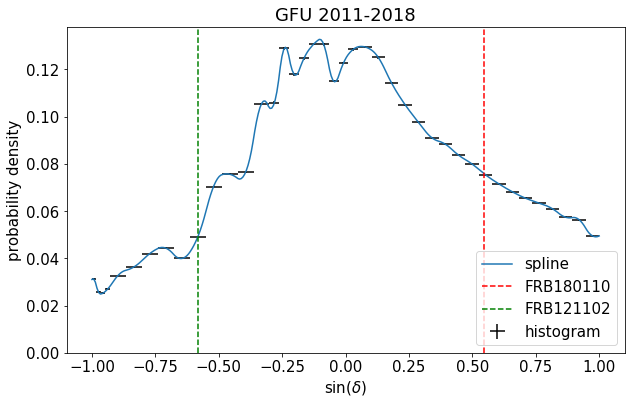

In [60]:
fig, ax = plt.subplots(figsize=(10,6))
hl.plot1d (ax, a.bg_space_param.h, crosses=True, color='k', label='histogram')
sd = np.linspace (-1, 1, 300)
ax.plot (sd, a.bg_space_param(sindec=sd), label='spline')
ax.set_ylim(0)
ax.set_title('GFU 2011-2018')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'probability density')

plt.axvline(np.sin(src1000[wn].dec[0]), ls='--',color='r', label='FRB180110')
plt.axvline(np.sin(src1000[ws].dec[0]), ls='--',color='g', label='FRB121102')
ax.legend(loc=4)
plt.savefig('./plots/spatial_pdf.png')